In [2]:
import pandas as pd 
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import string
from nltk.probability import FreqDist
import seaborn as sns
pd.options.display.max_rows = 999
pd.options.display.max_columns = 30
import lexnlp as lnlp
%matplotlib inline

In [146]:
df = pd.read_csv('justicewords.csv')

In [147]:
df.head()

,0,1
0,352 US 282 (1957),"[[[['that', 'instruction', 'i', 'take', 'it', ..."
1,353 US 586 (1957),"[[[['may', 'i', 'at', 'this', 'point', 'ask', ..."
2,352 US 599 (1957),"[[[['well', 'of', 'course', 'of', 'course', 'y..."
3,352 US 82 (1956),"[[[['mr', 'williams']]], [[['that', 'do', 'not..."
4,352 US 220 (1957),"[[[['mr', 'plauche', 'you', 'may', 'proceed']]..."


In [148]:
df.columns = ['case', 'text']

In [149]:
df[df.case =="353 US 373 (1957)"]

,case,text
45,353 US 373 (1957),"[[[['you', 'i', 'suppose', 'have', 'put', 'in'..."


In [150]:
df.text = df.text.apply(lambda x: str(x).replace('[','').replace(']', ''))

In [151]:
len(df)

6005

In [152]:
df.case = df.case.apply(lambda x: re.sub('(\d\d\d\d)', '', x))


In [153]:
df.case = df.case.apply(lambda x: x.lower())

In [154]:
df.case.apply(type).value_counts()

<class 'str'>    6005
Name: case, dtype: int64

In [155]:
from unidecode import unidecode
def remove_non_ascii_chars(title):
    return "".join([unidecode(char).rstrip('()').rstrip(' ') for char in title])      

In [156]:
remove_non_ascii_chars(df.case.iloc[0])

'352us282'

In [157]:
df.case = df.case.apply(lambda x: remove_non_ascii_chars(x))

In [158]:
df[df.case == '352us282']

,case,text
0,352us282,"'that', 'instruction', 'i', 'take', 'it', 'in'..."


## Importing CSV with Further Case Info and Target Variable

In [159]:
df2 = pd.read_csv("SCDB_2020_01_caseCentered_Citation.csv", encoding='cp1252')
                 

In [160]:
df2.head()

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,term,naturalCourt,chief,docket,caseName,...,voteUnclear,issue,issueArea,decisionDirection,decisionDirectionDissent,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,1946,1301,Vinson,24,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,...,0.0,80180.0,8.0,2.0,0.0,4.0,NaN,6.0,600.0,35 U.S.C. § 33,78.0,78.0,1,8,1
1,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,1946,1301,Vinson,12,CLEVELAND v. UNITED STATES,...,0.0,10500.0,1.0,1.0,0.0,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
2,1946-003,1946-003-01,1946-003-01-01,1946-003-01-01-01,11/18/1946,1,329 U.S. 29,67 S. Ct. 1,91 L. Ed. 22,1946 U.S. LEXIS 3037,1946,1301,Vinson,21,CHAMPLIN REFINING CO. v. UNITED STATES ET AL.,...,0.0,80250.0,8.0,2.0,0.0,1.0,NaN,2.0,207.0,NaN,84.0,78.0,1,5,4
3,1946-004,1946-004-01,1946-004-01-01,1946-004-01-01-01,11/25/1946,7,329 U.S. 40,67 S. Ct. 167,91 L. Ed. 29,1946 U.S. LEXIS 1696,1946,1301,Vinson,26,UNITED STATES v. ALCEA BAND OF TILLAMOOKS ET AL.,...,0.0,20150.0,2.0,2.0,0.0,4.0,NaN,6.0,600.0,49 Stat. 801,87.0,87.0,1,5,3
4,1946-005,1946-005-01,1946-005-01-01,1946-005-01-01-01,11/25/1946,1,329 U.S. 64,67 S. Ct. 154,91 L. Ed. 44,1946 U.S. LEXIS 2997,1946,1301,Vinson,50,"UNITED STATES v. HOWARD P. FOLEY CO., INC.",...,0.0,80060.0,8.0,2.0,0.0,7.0,NaN,NaN,NaN,NaN,78.0,87.0,1,6,3


## Merging with Text DF

In [161]:
target_name_df = df2[['partyWinning', 'usCite', 'decisionDirection', 'majVotes']].copy()

In [162]:
target_name_df.columns = ['target', 'case', 'lib_or_con', 'majVotes']

In [163]:
target_name_df['case'] = target_name_df['case'].apply(lambda x: str(x).replace('.', '').lower().replace(' ', ''))

In [164]:
target_name_df.head()

,target,case,lib_or_con,majVotes
0,1.0,329us1,2.0,8
1,0.0,329us14,1.0,6
2,0.0,329us29,2.0,5
3,0.0,329us40,2.0,5
4,1.0,329us64,2.0,6


In [165]:
target_name_df[target_name_df.case == '352us282' ]

,target,case,lib_or_con,majVotes
1129,1.0,352us282,2.0,6


In [166]:
final_df = df.merge(target_name_df, on ='case')

In [167]:
final_df.to_csv('Final Merge.csv')

Only 1400 rows this is gonna be a process. Lets see if we can levarage some of the citation data. OK I went through and changed everything and now im up to 5700 cases, thats plenty for me.

In [168]:
final_df = final_df[final_df.majVotes < 7]

In [169]:
final_df.head()

,case,text,target,lib_or_con,majVotes
0,352us282,"'that', 'instruction', 'i', 'take', 'it', 'in'...",1.0,2.0,6
1,353us586,"'may', 'i', 'at', 'this', 'point', 'ask', 'to'...",1.0,2.0,4
5,352us249,"'you', 'might', 'wait', 'just', 'a', 'moment',...",0.0,2.0,5
9,354us147,"'what', 'be', 'the', 'second', 'general', 'wha...",0.0,2.0,5
10,352us407,"'this', 'be', 'all', 'before', 'any', 'evidenc...",1.0,1.0,6


In [170]:
final_df.target.value_counts()

1.0    1435
0.0    1022
Name: target, dtype: int64

In [171]:
final_df = final_df[final_df.target!= 2.0]

In [40]:
final_df = final_df.dropna()

In [41]:
import math
final_df.target = final_df.target.apply(lambda x: math.trunc(x))


In [42]:
final_df.target.value_counts()

1    1435
0    1021
Name: target, dtype: int64

In [75]:
plt.style.use('fivethirtyeight')

## Text EDA

### Most Common Words

First lets take a look at the most common words found in all cases. 

In [172]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com', 'http', '-', '–', '—', 'co', 'wa', 'ha', '1', 'amp']
sw_set1 = set(sw_list)

In [173]:
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set1]
    return stopwords_removed 

In [174]:
wordsls = list(map(process_article, final_df.text))

In [175]:
wordsls = [item for sublist in wordsls for item in sublist]

In [176]:
freq_dis = FreqDist(wordsls)

In [177]:
words_df = pd.DataFrame(freq_dis.most_common())


In [178]:
words_df.columns = ('word', 'count')

In [179]:
stop = words_df.word.values[0:500]


Text(0.5, 0, '')

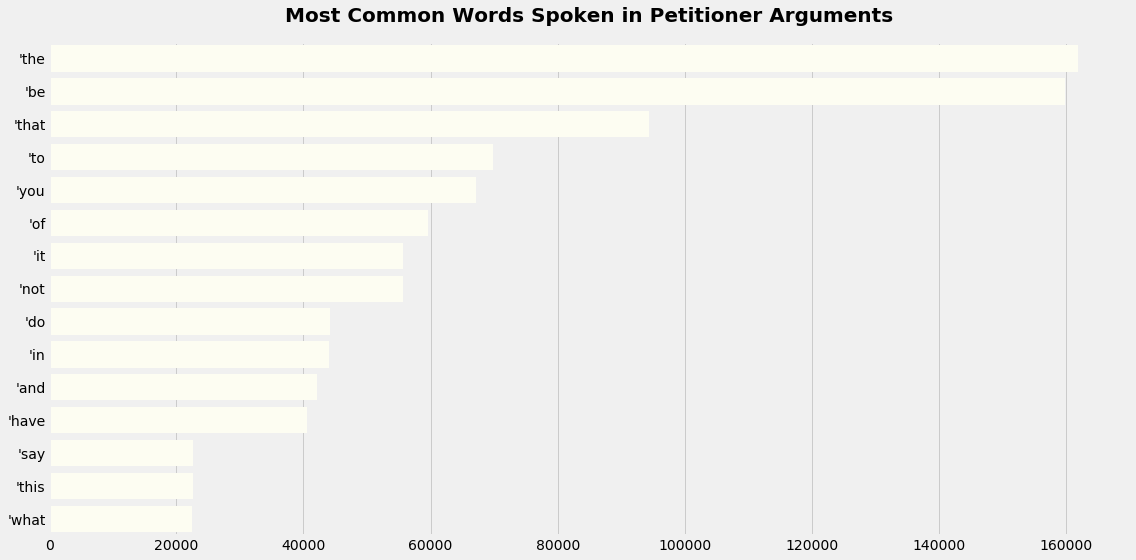

In [180]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.barplot('count', 'word', data = words_df.head(15), ax = ax, palette = ['ivory'])
ax.set_title('Most Common Words Spoken in Petitioner Arguments',  size = 20, fontweight = 'bold',pad = 20, loc= 'center')
fig.set_tight_layout(True)
ax.set_ylabel('')
ax.set_xlabel('')

There are no surprises here, If you had asked me before this project what the most common words used in legal arguments were, it might look alot like this list. I don't know what we are paying lawyers so much for, theres not even any latin!

In [111]:
sw_list2 = stopwords.words('english')
sw_list2 += list(string.punctuation)
sw_list2 += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'u','said', 'one', 'com', 'http', '-', '–', '—', 'co', 'wa', 'ha', '1', 'amp']
sw_list2 += list(stop)
sw_set2 = set(sw_list2)

These words were also the most common in both the clasees, so I decided to use them as stopwords since they tell us very little and are uninteresting in general.

### Most Common Words Winning

In [112]:
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set2]
    return stopwords_removed 

wordsls2 = list(map(process_article, final_df[final_df.target == 1]['text']))

wordsls2 = [item for sublist in wordsls2 for item in sublist]

freq_dis2 = FreqDist(wordsls2)

words_df2 = pd.DataFrame(freq_dis2.most_common())

words_df2.columns = ('word', 'count')

Text(0.5, 0, '')

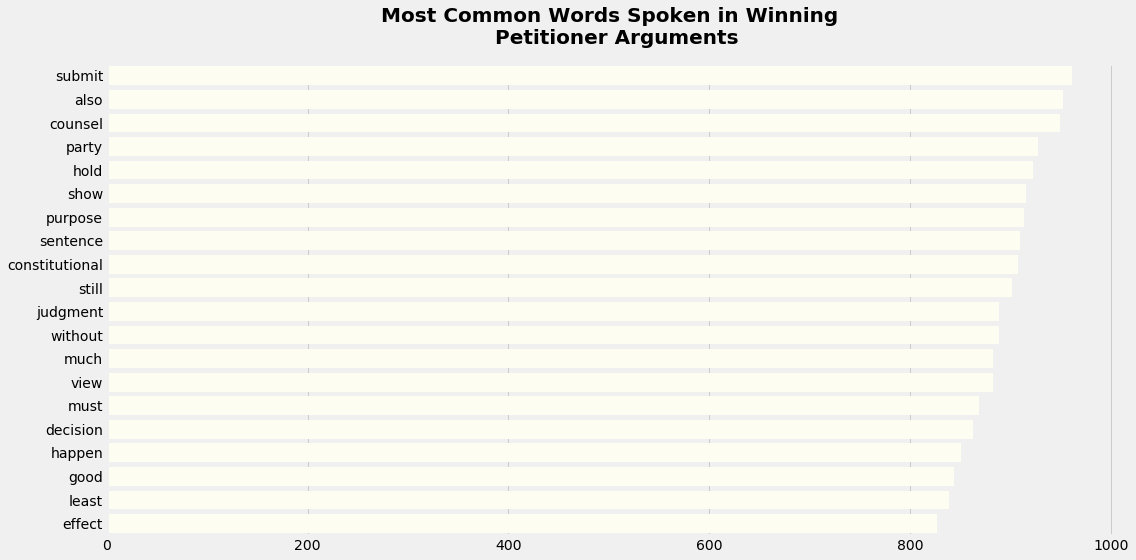

In [113]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.barplot('count', 'word', data = words_df2.head(20), ax = ax, palette = ['ivory'])
ax.set_title('Most Common Words Spoken in Winning \n Petitioner Arguments',  size = 20, fontweight = 'bold',pad = 20, loc= 'center')
fig.set_tight_layout(True)
ax.set_ylabel("")
ax.set_xlabel("")

More generally boring words and legalese, lets see if theres any differences with losing arguments.

### Most Common Words Losing

In [114]:
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set2]
    return stopwords_removed 

wordsls3 = list(map(process_article, final_df[final_df.target == 0]['text']))

wordsls3 = [item for sublist in wordsls3 for item in sublist]

freq_dis3 = FreqDist(wordsls3)

words_df3 = pd.DataFrame(freq_dis3.most_common())

words_df3.columns = ('word', 'count')



In [115]:
top15W = list(words_df2.word[0:20])
top15L = list(words_df3.word[0:20])
colors_dif = []

for x in range(0,20):
    if top15L[x] not in top15W:
        colors_dif.append('tab:red')
    elif top15W[x] == top15L[x]:
        colors_dif.append('ivory')
    else:
         colors_dif.append('tan')


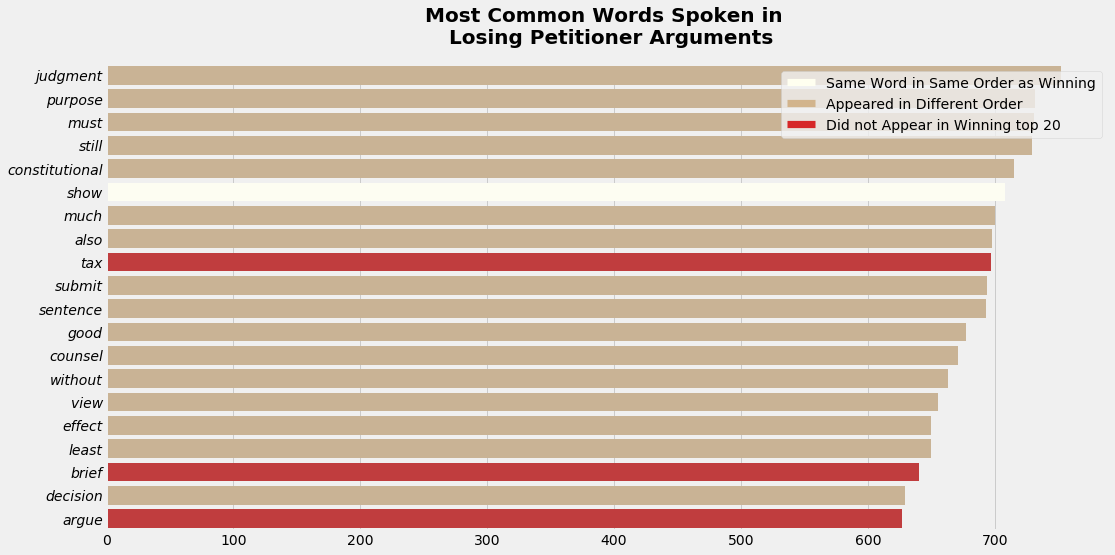

In [116]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
sns.barplot('count', 'word', data = words_df3.head(20), palette = colors_dif, ax = ax)
ax.set_title('Most Common Words Spoken in \n Losing Petitioner Arguments',  size = 20, fontweight = 'bold', pad = 20, loc= 'center')
ax.set_yticklabels(labels = words_df3.word[0:20], style= 'italic', );
ax.set_ylabel('')
ax.set_xlabel("")
ax.legend(['Same Word in Same Order as Winning', 'Appeared in Different Order', "Did not Appear in Winning top 20"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('ivory')
leg.legendHandles[1].set_color('tan')
leg.legendHandles[2].set_color('tab:red')
plt.savefig('wordslosing.png')

The two classes are very similar based on the top 15 most common words in each, Congress and give being the two words that appear more in losing arguments. Give makes intuitive sense as asking the court to give your side something goes against the status quo they are more likely to maintain. Congress is very interesting, it would seem that arguments by the petitioner centered around Congress are more likely to lose, although we cannot see the relationship, is the court deffering to Congress or ruling against them?

# NLP Feature Engineering and EDA

## Tokenizing all that sweet sweet text


In [181]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+')

final_df.text = final_df.text.apply(lambda x: tokenizer.tokenize(x))

In [182]:
lemmatizer = WordNetLemmatizer() 

def lemm_text(words):
    lem = []
    for word in words:
        lem.append(lemmatizer.lemmatize(word))
    return lem  

In [183]:
final_df.text = final_df.text.apply(lambda x: lemm_text(x))

In [184]:
final_df.head()

,case,text,target,lib_or_con,majVotes
0,352us282,"[that, instruction, i, take, it, in, effect, i...",1.0,2.0,6
1,353us586,"[may, i, at, this, point, ask, to, be, declare...",1.0,2.0,4
5,352us249,"[you, might, wait, just, a, moment, until, cou...",0.0,2.0,5
9,354us147,"[what, be, the, second, general, what, be, the...",0.0,2.0,5
10,352us407,"[this, be, all, before, any, evidence, be, tak...",1.0,1.0,6


# Modeling 


I will be using accuracy as my metric as this model will have little actionable impact, its not important to maximise other metrics. The more accurate the model the better a data point it will be for legal prognosticators.

## Train Test Split

In [185]:
final_df.text = final_df.text.apply(lambda x: ','.join(x))
final_df.text =final_df.text.apply(lambda x: x.replace(',',' '))

In [186]:
X = final_df.text
Y = final_df.target
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [187]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += list(stop)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com','-', '–', '—', 'co', 'wa', 'ha', '1', 'amp']
sw_set = set(sw_list)

In [188]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X, Y, test_size=0.20, random_state=34)
tfidf = TfidfVectorizer(ngram_range= (1,2), stop_words= sw_set)

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['able', 'accept', 'act', 'action', 'activity', 'actually', 'address', 'agency', 'agree', 'agreement', 'allow', 'also', 'always', 'amendment', 'amount', 'another', 'answer', 'anybody', 'anything', 'appeal', 'apply', 'area', 'argue', 'argument', 'arrest', 'ask', 'assume', 'attorney', 'authority', 'back', 'bad', 'bank', 'bar', 'base', 'basis', 'believe', 'benefit', 'beyond', 'board', 'brief', 'bring', 'burden', 'business', 'california', 'call', 'car', 'carry', 'case', 'certain', 'certainly', 'challenge', 'change', 'charge', 'child', 'circuit', 'circumstance', 'city', 'civil', 'claim', 'class', 'clause', 'clear', 'client', 'come', 'commission', 'commit', 'common', 'company', 'complaint', 'concede', 'concern', 'condition', 'conduct', 'congress', 'consider', 'constitu

## Untuned RFC (baseline)

In [189]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0, class_weight= 'balanced')

In [190]:
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [127]:
from sklearn.metrics import f1_score
rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.5955

F1 Score: 0.7209


The untuned RFC will serve as my baseline model, Its was fairly inaccurate with a score of .563 but that is to be expected as the classes are so similar in terms of text and becuase even legal scholars struggle in predicting close cases. 

In [54]:
confusion = confusion_matrix(y_test_lem, rf_test_preds_lem)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 249
True Negatives: 34
 False Positives: 172
 False Negatives: 37



Based on the confusion matrix it seems like the RFC is way over predicting that the petitioner will win. The classes were not nearly this imbalanced but maybe there is so little difference that it defualts to predicting in favor of the dominant class.

## Multinomial Naive Bayes Classifier

In [55]:
from sklearn.naive_bayes import MultinomialNB

In [56]:
nb_classifier = MultinomialNB(alpha = .01)

In [57]:
nb_classifier.fit(tfidf_data_train_lem, y_train_lem)
nb_test_preds_lem = nb_classifier.predict(tfidf_data_test_lem)


In [58]:
nb_acc_score_lem = accuracy_score(y_test_lem, nb_test_preds_lem)
nb_f1_score_lem = f1_score(y_test_lem, nb_test_preds_lem)

In [59]:
print('Naive Bayes with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(nb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(nb_f1_score_lem))

Naive Bayes with Lemmatization Features
Testing Accuracy: 0.5732

F1 Score: 0.6965


The Naive Bayes model did a little better but not a by a huge margin. 

In [91]:
confusion = confusion_matrix(y_test_lem, rf_test_preds_lem)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 249
True Negatives: 34
 False Positives: 172
 False Negatives: 37



In [483]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

['zwiener question', 'gloss put', 'gloss example', 'gloss first', 'gloss good', 'gloss history', 'gloss honor', 'gloss individually', 'gloss intend', 'gloss issue']


In [484]:
feature_names = tfidf.get_feature_names()
top10 = np.argsort(nb_classifier.coef_[0])[-10:]

print(" ".join(feature_names[j] for j in top10))

mr make right well state think say would case court


## Tuned RFC

In [360]:
from sklearn.model_selection import GridSearchCV

In [419]:
param_grid = { 
    'n_estimators': [2,3,4],
    'criterion': ['gini'],
    'max_depth': range(2,10),
    'max_features': ['auto']
}

In [420]:
grid_tree =GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [421]:
grid_tree.fit(tfidf_data_train_lem, y_train_lem)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   44.4s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': range(2, 10),
                         'max_features': ['auto'], 'n_estimators': [2, 3, 4]},
             scoring='accuracy', verbose=1)

In [423]:
grfc_preds =grid_tree.predict(tfidf_data_test_lem)
accuracy_score(grfc_preds, y_test_lem)

0.5772357723577236

In [424]:
grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'n_estimators': 2}

so far this is the best model but still not amazing.

## SVC

In [191]:
from sklearn.svm import SVC

In [192]:
svc = SVC(class_weight= 'balanced', kernel = 'sigmoid')

In [193]:
svc.fit(X= tfidf_data_train_lem, y= y_train_lem)

SVC(class_weight='balanced', kernel='sigmoid')

In [194]:
preds = svc.predict(tfidf_data_test_lem)

In [195]:
accuracy_score(preds, y_test_lem)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [391]:
param_gridsvc = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [396]:
grid_svc = GridSearchCV(SVC(), param_gridsvc, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

In [397]:
grid_svc.fit(tfidf_data_train_lem, y_train_lem)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 39.2min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [399]:
predsgsvc = grid_svc.predict(tfidf_data_test_lem)

In [400]:
accuracy_score(predsgsvc, y_test_lem)

0.5813008130081301

# Combining With Another Model